## Author
Paweł Rzepiński

## Data

In [3]:
!wget -N --directory-prefix=data/ http://hgdownload.cse.ucsc.edu/goldenpath/hg19/database/cpgIslandExt.txt.gz 
!wget -N --directory-prefix=data/ http://hgdownload.soe.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeHaibMethyl450/wgEncodeHaibMethyl450A549Etoh02SitesRep1.bed.gz
!wget -N --directory-prefix=data/ http://hgdownload.cse.ucsc.edu/goldenPath/hg19/bigZips/hg19.chrom.sizes

--2019-11-23 12:54:14--  http://hgdownload.cse.ucsc.edu/goldenpath/hg19/database/cpgIslandExt.txt.gz
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘data/cpgIslandExt.txt.gz’ not modified on server. Omitting download.

--2019-11-23 12:54:15--  http://hgdownload.soe.ucsc.edu/goldenPath/hg19/encodeDCC/wgEncodeHaibMethyl450/wgEncodeHaibMethyl450A549Etoh02SitesRep1.bed.gz
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘data/wgEncodeHaibMethyl450A549Etoh02SitesRep1.bed.gz’ not modified on server. Omitting download.

--2019-11-23 12:54:16--  http://hgdownload.cse.ucsc.edu/goldenPath/hg19/bigZips/hg19.chrom.sizes
Re

## Imports

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import pybedtools # requires bedtools CLI - https://bedtools.readthedocs.io/en/latest/

## HG19 sizes

In [5]:
hg19_df = pd.read_csv("data/hg19.chrom.sizes", sep="\t", header=None, names=["chr", "chr_size"])

In [6]:
# Only autosomalchromosomes: chr1 - ch22 
autosomal = [f"chr{i}" for i in range(1, 23)]
hg19_df = hg19_df[hg19_df.chr.isin(autosomal)]

In [7]:
# Ensure bedtools sort order
hg19_df = hg19_df.sort_values("chr")
hg19_df.head()

,chr,chr_size
0,chr1,249250621
10,chr10,135534747
11,chr11,135006516
12,chr12,133851895
13,chr13,115169878


In [8]:
hg19_df.to_csv("data/hg19.chrom.sizes", header=None, index=False, sep="\t")

## CPG

In [9]:
cpg_colnames = ["chr", "start", "end"]
cpg_df = pybedtools.BedTool("data/cpgIslandExt.txt.gz").to_dataframe(header=None, usecols=range(1, 4), names=cpg_colnames)
cpg_df.head()

,chr,start,end
0,chr1,28735,29810
1,chr1,135124,135563
2,chr1,327790,328229
3,chr1,437151,438164
4,chr1,449273,450544


In [10]:
# Only autosomalchromosomes: chr1 - ch22 
autosomal = [f"chr{i}" for i in range(1, 23)]
cpg_df = cpg_df[cpg_df.chr.isin(autosomal)]

In [11]:
cpg = pybedtools.BedTool.from_dataframe(cpg_df).sort()
genome = 'data/hg19.chrom.sizes'
flank_size = 2000

In [12]:
cpg.saveas('cpg.bed')
print(cpg.head())

chr1	28735	29810
 chr1	135124	135563
 chr1	327790	328229
 chr1	437151	438164
 chr1	449273	450544
 chr1	533219	534114
 chr1	544738	546649
 chr1	713984	714547
 chr1	762416	763445
 chr1	788863	789211
 None


In [13]:
shores = cpg.flank(g=genome, b=flank_size).subtract(cpg).sort().merge()
shores.saveas('shores.bed')
print(shores.head())

chr1	26735	28735
 chr1	29810	31810
 chr1	133124	135124
 chr1	135563	137563
 chr1	325790	327790
 chr1	328229	330229
 chr1	435151	437151
 chr1	438164	440164
 chr1	447273	449273
 chr1	450544	452544
 None


In [14]:
shelves = cpg.slop(g=genome, b=flank_size).flank(g=genome, b=flank_size).subtract(shores).subtract(cpg).sort().merge()
shelves.saveas('shelves.bed')
print(shelves.head())

chr1	24735	26735
 chr1	31810	33810
 chr1	131124	133124
 chr1	137563	139563
 chr1	323790	325790
 chr1	330229	332229
 chr1	433151	435151
 chr1	440164	442164
 chr1	445273	447273
 chr1	452544	454544
 None


In [15]:
seas = cpg.slop(g=genome, b=2*flank_size).merge().complement(g=genome).sort()
seas.saveas('seas.bed')
print(seas.head())

chr1	0	24735
 chr1	33810	131124
 chr1	139563	323790
 chr1	332229	433151
 chr1	442164	445273
 chr1	454544	529219
 chr1	538114	540738
 chr1	550649	709984
 chr1	718547	758416
 chr1	767445	784863
 None


## Methylations

In [16]:
meth_colnames = ["chr", "start", "end"]
meth_raw = pybedtools.BedTool("data/wgEncodeHaibMethyl450A549Etoh02SitesRep1.bed.gz").sort()
meth_df = meth_raw.to_dataframe(header=None, usecols=range(0, 3), names=meth_colnames)
meth_df.head()

,chr,start,end
0,chr1,15865,15915
1,chr1,18827,18877
2,chr1,29407,29457
3,chr1,29425,29475
4,chr1,29435,29485


In [17]:
meth_df["start"] = (meth_df.start + (meth_df.end - meth_df.start)/2).astype(int)
meth_df["end"] = meth_df.start + 1
meth_df.head()

,chr,start,end
0,chr1,15890,15891
1,chr1,18852,18853
2,chr1,29432,29433
3,chr1,29450,29451
4,chr1,29460,29461


In [18]:
# Only autosomalchromosomes: chr1 - ch22 
meth_df = meth_df[meth_df.chr.isin(autosomal)]

In [19]:
meth = pybedtools.BedTool.from_dataframe(meth_df)

In [20]:
plot_data = list()
for region_name, region in zip(["cpg", "shores", "shelves", "seas"], [cpg, shores, shelves, seas]):
    intersection = meth.intersect(b=region,u=True)
    hits = len(intersection)
    plot_data += [(region_name, hits)]

In [21]:
plot_df = pd.DataFrame(plot_data, columns=["region_name", "hits"])
plot_df["percentage"] = plot_df.hits / sum(plot_df.hits)
plot_df

,region_name,hits,percentage
0,cpg,132094,0.280532
1,shores,122913,0.261034
2,shelves,45457,0.096538
3,seas,170406,0.361896


In [22]:
# Check if all and not more meth entries have assignment
assert sum(plot_df.hits) == len(meth_df)

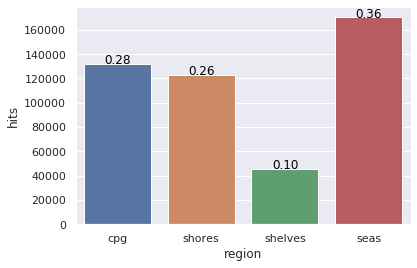

In [23]:
sns.set(style="darkgrid")
g = sns.barplot(x="region_name", y="hits", data=plot_df)
g.set(xlabel='region', ylabel='hits')
for index, row in plot_df.iterrows():
    g.text(row.name, row.hits, f"{round(row.percentage,2):0.2f}", color='black', ha="center")